In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from ITrackerData import ITrackerData, SubtractMean
from ITrackerModel import ITrackerModel
import cv2
from PIL import Image, ImageDraw
#import face_recognition
import os
import numpy as np
import torchvision.transforms as transforms
import csv
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-s6tejw0s because the default path (/tmp/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Gaze###
2.789325153374233
-2.773742331288344
	Reading metadata from mean_face_224.mat...
	Reading metadata from mean_left_224.mat...
	Reading metadata from mean_right_224.mat...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232


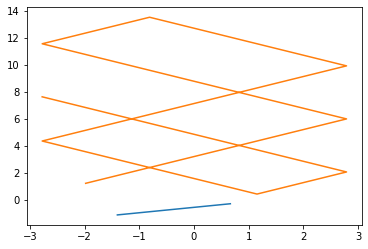

In [52]:
# Load a pre-trained version of MobileNetV2
torch_model = ITrackerModel()
# SubtractMean = SubtractMean()
# torch_model = torch.nn.DataParallel(torch_model)

# Load Weights
checkpoint = torch.load('checkpoint.pth.tar',map_location=torch.device('cpu'))
torch_model.load_state_dict(checkpoint['state_dict'])
filePath = '../vid1.MP4'
torch_model.eval()

# feature_names = ['calibration.face.distance', 'calibration.face.pitch', 'calibration.face.yaw', 'calibration.face.translation_x', 'calibration.face.translation_y', 'calibration.eyes.pitch', 'calibration.eyes.yaw', 'calibration.lookatpoint.x', 'calibration.lookatpoint.y', 'calibration.coordinates.x', 'calibration.coordinates.y', 'ModCoordinateX', 'ModCoordinateY', 'ModeyesPitch', 'ModeyesYaw', 'StringA', 'StringB', 'StringC', 'StringD', 'lighting', 'temperature', 'numberofModel', 'widthDevice', 'heightDevice', 'DistanceBetweenEyes', 'Blinks', 'calibration.lefteye.eyeBlink', 'calibration.lefteye.eyeLookDown', 'calibration.lefteye.eyeLookIn', 'calibration.lefteye.eyeLookOut', 'calibration.lefteye.eyeLookUp', 'calibration.lefteye.eyeSquint', 'calibration.lefteye.eyeWide', 'calibration.righteye.eyeBlink', 'calibration.righteye.eyeLookDown', 'calibration.righteye.eyeLookIn', 'calibration.righteye.eyeLookOut', 'calibration.righteye.eyeLookUp', 'calibration.righteye.eyeSquint', 'calibration.righteye.eyeWide', 'ignore1','ignore2', 'calibration.time.referenceTime']

device = 'iPhone XR'
device_properties = pd.read_csv('/hpc/gsin255/Documents/MLPipeline/apple_device_properties.csv')
prop = device_properties[device_properties['model'] == device].T.iloc[:,0]
scale_factor = (prop.pt_to_px*2.54)/prop.ppi
device_width = prop.width_points
device_height = prop.height_points

xgaze, ygaze = [], []
with open('../vid1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for index,row in enumerate(csv_reader):
        if index==16:
            xgaze=np.array(row).astype(float)
        if index==17:
            ygaze=np.array(row).astype(float)
    # lines = csv_file.readlines()
    # xgaze = np.array(lines[16])
    # ygaze = np.array(lines[17])
# print(xgaze.shape)
# xgaze = [(x-(device_width/2))*scale_factor for x in xgaze]
# ygaze = [(y-(device_height/2))*scale_factor for y in ygaze]
xgaze -= device_width/2
xgaze *= scale_factor
#ygaze -= device_height/2
ygaze *= scale_factor
print("Gaze###")
print(max(xgaze))
print(min(xgaze))

def loadMetadata(filename, silent = False):
    try:
        # http://stackoverflow.com/questions/6273634/access-array-contents-from-a-mat-file-loaded-using-scipy-io-loadmat-python
        if not silent:
            print('\tReading metadata from %s...' % filename)
        metadata = sio.loadmat(filename, squeeze_me=True, struct_as_record=False)
    except:
        print('\tFailed to read the meta file "%s"!' % filename)
        return None
    return metadata

MEAN_PATH = './'
faceMean = loadMetadata('mean_face_224.mat')['image_mean']
eyeLeftMean = loadMetadata('mean_left_224.mat')['image_mean']
eyeRightMean = loadMetadata('mean_right_224.mat')['image_mean']

 
countframe = -1
cap = cv2.VideoCapture(filePath)
if (cap.isOpened()== False):
    print("Error opening video stream or file")

# def getleftmosteye(eyes):
#     leftmost=9999999
#     leftmostindex=-1
#     for i in range(0,2):
#     if eyes[i][0]<leftmost:
#         leftmost=eyes[i][0]
#         leftmostindex=i
#     return eyes[leftmostindex]

predictions = []
errorx = []
errory = []

# while(cap.isOpened()):
#           firstFrame = True
#           ret, frame = cap.read()
#         #   if countframe == 4:
#         #         cap.release()
#           if ret == True :
#             countframe = countframe + 1
#             print(countframe)
#             if countframe < 698:
#                faceMean += frame
#           else:
#              break
# else:
#     break

# faceMean /= 698

# cap.release()
# cap = cv2.VideoCapture(filePath)

while(cap.isOpened()):
          firstFrame = True
          ret, frame = cap.read()
        #   if countframe == 4:
        #         cap.release()
          if ret == True :
            countframe = countframe + 1
            print(countframe)
            if countframe < 698:
                # countframe = 0
                image = frame
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Convert into grayscale
                # Convert into RGB

                
                # Load the cascade
                face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
                left_eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_lefteye_2splits.xml')
                right_eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_righteye_2splits.xml')

                # Detect faces
                faces = face_cascade.detectMultiScale(gray, 1.1, 4)
                left_eye = left_eye_cascade.detectMultiScale(gray, 1.1, 4)
                right_eye = right_eye_cascade.detectMultiScale(gray, 1.1, 4)
                
                # FACE
                areas = [w*h for x,y,w,h in faces]
                i_biggest = np.argmax(areas)
                biggest_face = faces[i_biggest]
                (face_x, face_y, face_w, face_h) = biggest_face
                # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                face = image[face_y:face_y + face_h, face_x:face_x + face_w]
                face = cv2.resize(face, (224,224), interpolation = cv2.INTER_AREA)
                # cv2.imwrite('Face.jpg',faces)
                # print("Face saved")

                # GRID
                height, width = image.shape[:2]
                grid = [int(face_x*25/width), int(face_y*25/height), int((face_x+face_w)*25/width), int((face_y+face_h)*25/height)]
                grid_mask = np.zeros((25, 25))
                grid_mask[grid[0]:grid[2]+1, grid[1]:grid[3]+1] = 1
                
                # resized_img = cv2.resize(image, (25,25), interpolation = cv2.INTER_AREA)
                # cv2.rectangle(resized_img, (grid[1], grid[0]), (grid[3], grid[2]), (0, 0, 255), 1) 
                # cv2.imwrite("Grid2.jpg", resized_img)
                # cv2.imwrite("Grid_gray2.jpg",grid_mask*255)
                
                # LEFT EYE
                leftmost_x = face_x+face_w
                for (left_eye_x, left_eye_y, left_eye_w, left_eye_h) in left_eye:
                    if left_eye_x>face_x and (left_eye_x+left_eye_w)<(face_x+face_w) and left_eye_y>face_y and (left_eye_y+left_eye_h)<(face_x+face_h):
                        if left_eye_x<leftmost_x:
                    # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                            left_eye = image[left_eye_y:left_eye_y + left_eye_h, left_eye_x:left_eye_x + left_eye_w]
                            leftmost_x = left_eye_x
                left_eye = cv2.resize(left_eye, (224,224), interpolation = cv2.INTER_AREA)
                # cv2.imwrite('Left_eye.jpg',left_eye)
                # print("Left eye saved")

                # RIGHT EYE
                rightmost_x = 0
                for (right_eye_x, right_eye_y, right_eye_w, right_eye_h) in right_eye:
                    if right_eye_x>face_x and (right_eye_x+right_eye_w)<(face_x+face_w) and right_eye_y>face_y and (right_eye_y+right_eye_h)<(face_x+face_h):
                    # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                        if right_eye_x > rightmost_x:
                            right_eye = image[right_eye_y:right_eye_y + right_eye_h, right_eye_x:right_eye_x + right_eye_w]
                            rightmost_x = right_eye_x
                # cv2.imwrite('Right_eye.jpg',right_eye)
                right_eye = cv2.resize(right_eye, (224,224), interpolation = cv2.INTER_AREA)
                # print("Right eye saved")

                # cv2.imwrite('Frame.jpg',frame)
                # print("Frame saved")

                grid_mask = grid_mask.flatten()

                imSize = (224,224)

                transformFace = transforms.Compose([
                    # #transforms.Resize(imSize),
                    transforms.ToTensor(),
                    SubtractMean(meanImg=faceMean),
                ])
                transformEyeL = transforms.Compose([
                    # transforms.Resize(imSize),
                    transforms.ToTensor(),
                    SubtractMean(meanImg=eyeLeftMean),
                ])
                transformEyeR = transforms.Compose([
                    #transforms.Resize(imSize),
                    transforms.ToTensor(),
                    SubtractMean(meanImg=eyeRightMean),
                ])
      
                imFace =  transformFace(face)
                imEyeL =  transformEyeL(left_eye)
                imEyeR =  transformEyeR(right_eye)
                faceGrid = torch.FloatTensor(grid_mask)
                imFace = torch.unsqueeze(imFace, 0)
                imEyeL = torch.unsqueeze(imEyeL, 0)
                imEyeR = torch.unsqueeze(imEyeR, 0)
                faceGrid = torch.unsqueeze(faceGrid, 0)
                # torch.tensor.expand(imFace)
                # print("shape")
                # print(face.shape, left_eye.shape,right_eye.shape, grid_mask.shape)
                # print(imFace.shape, imEyeL.shape,imEyeR.shape, faceGrid.shape)

                imFace = torch.autograd.Variable(imFace, requires_grad = False)
                imEyeL = torch.autograd.Variable(imEyeL, requires_grad = False)
                imEyeR = torch.autograd.Variable(imEyeR, requires_grad = False)
                faceGrid = torch.autograd.Variable(faceGrid, requires_grad = False)
                # imFace = self.ttransformEyeLransformFace(imFace)
            #             self.transformFace = transforms.Compose([
            # transforms.Resize(self.imSize),
            # transforms.ToTensor(),
            # SubtractMean(meanImg=self.faceMean),
        # ])
                # arr_reshaped = np.transpose(arr, (2, 1, 0))
                
                with torch.no_grad():
                    out = torch_model(imFace,
                        imEyeL,
                        imEyeR,
                        faceGrid)
                # print(out)
                # print(out.numpy())
                predictions.append(out.numpy()[0])
                # tensor_array.cpu().detach().numpy()
                errorx.append(np.abs(xgaze[countframe]-out.numpy()[0][0]))
                errory.append(np.abs(ygaze[countframe]-out.numpy()[0][1]))

                # print("Error X:", np.mean(errorx))
                # print("Error Y:",np.mean(errory))


                # pd.DataFrame(predictions).to_csv("predictions.csv", index=False)
                # pd.DataFrame(errorx).to_csv("errorx.csv", index=False)
                # pd.DataFrame(errory).to_csv("errory.csv", index=False)

                # print(out)

                # print(grid_mask)
                # # cv2.imwrite('Grid.jpg',grid_mask)
                # # image_int = np.array(255*grid_mask, np.uint8)
                # # cv2.imwrite('Grid_gray.jpg',image_int)
                
                # resized_image = cv2.resize(image, (25,25), interpolation = cv2.INTER_AREA)

                
                # cv2.rectangle(resized_image, (grid[0], grid[1]), (grid[2], grid[3]), (0, 0, 255), 2)
                # cv2.imwrite('Grid.jpg',resized_image)
                # cv2.bitwise_and('Frame.jpg', )

                # face_landmarks_list = face_recognition.face_landmarks(image)
                # pil_image = Image.fromarray(image)
                # d = ImageDraw.Draw(pil_image)
                
                # for face_landmarks in face_landmarks_list:
                  
                    # Print the location of each facial feature in this image
                    #for facial_feature in face_landmarks.keys():
                        #print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))
                
                    # Let's trace out each facial feature in the image with a line!
                    # for facial_feature in face_landmarks.keys():
                        # d.line(face_landmarks[facial_feature], width=5)
                
                # Show the picture
                # if firstFrame == True:
                    # pil_image.show()
                    # firstFrame = False
                
                # if face_landmarks_list != []:
                    # left_eye = face_landmarks_list[0]['left_eye']
                    # right_eye = face_landmarks_list[0]['right_eye']
            else:
                break
          else:
              break      
                          
cap.release()

print("Count Frame", countframe)
print("# of Samples",len(xgaze))

print("Error X:", np.mean(errorx))
print("Error Y:",np.mean(errory))

pd.DataFrame(predictions).to_csv("predictions_default.csv", index=False, header=False)
pd.DataFrame(errorx).to_csv("errorx_default.csv", index=False, header=False)
pd.DataFrame(errory).to_csv("errory_default.csv", index=False, header=False)
pd.DataFrame({"xgaze":xgaze,"ygaze":ygaze}).to_csv("actual.csv", index=False, header=False)

predictions = np.array(predictions)
plt.plot(predictions[:,0],predictions[:,1]*-1)
plt.plot(xgaze,ygaze)
plt.savefig('plot_default.jpg')


# # Set the model in evaluation mode.
# torch_model.eval()

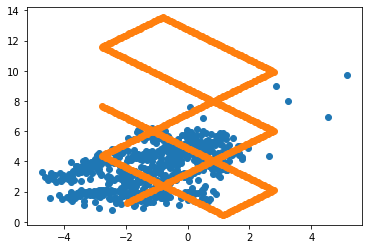

In [53]:
predictions_csv = pd.read_csv('predictions.csv',header=None).values.T
plt.scatter(predictions_csv[0],predictions_csv[1]*-1)
actual_csv = pd.read_csv('actual.csv',header=None).values.T
plt.scatter(actual_csv[0],actual_csv[1])
# len(predictions_csv[:,0])


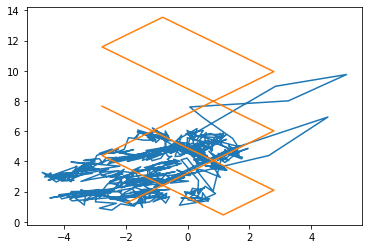

In [58]:
pd.DataFrame(predictions).to_csv("predictions_bgr2rgb.csv", index=False, header=False)
pd.DataFrame(errorx).to_csv("errorx_bgr2rgb.csv", index=False, header=False)
pd.DataFrame(errory).to_csv("errory_bgr2rgb.csv", index=False, header=False)
pd.DataFrame({"xgaze":xgaze,"ygaze":ygaze}).to_csv("actual.csv", index=False, header=False)

predictions = np.array(predictions)
plt.plot(predictions[:,0],predictions[:,1]*-1)
plt.plot(xgaze,ygaze)
plt.savefig('plot_bgr2rgb.jpg')